# Experiments with Taiwan

In [1]:
pip install scikit-lego[cvxpy]

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fairlearn

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [38]:
import time
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import PartialDependenceDisplay
from lime import lime_tabular
import shap
from cfmining.algorithms import MAPOCAM, BruteForce, Greedy
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier
from cfmining.visualization import buildTable, PlotCounterfactuals
from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet
import joblib

from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklego.linear_model import EqualOpportunityClassifier
#from fairgbm import FairGBMClassifier
from fairlearn.postprocessing import ThresholdOptimizer


import credit_pipeline.data_exploration as dex
from credit_pipeline.training import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and Cleaning

In [4]:
seed_number = 0

In [5]:
path = ""
df = dex.read_csv_encoded(path, 'Taiwan.csv')
df.columns = df.iloc[0, :].tolist()
df = df.iloc[1:, :]
df = df.drop(columns = ["ID"])

In [6]:
columns_to_drop = dex.check_missing(df, 50,  False)
columns_to_drop

[]

In [7]:
num_cols = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
            "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2",
            "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6", "default payment next month"]
df[num_cols] = df[num_cols].astype(float)

In [8]:
df_cols = df.columns.to_list()
obj_cols = dex.list_by_type(df, ['O'])
obj_cols

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [9]:
print(dex.list_no_variation_cols(df))
print(dex.list_contin_cols(df))
print(dex.list_by_unique(df, 2))

[]
['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
['SEX', 'default payment next month']


In [10]:
df["SEX"] = df["SEX"].apply(lambda x : "female" if x == "2" else "male")

## Training Basic Models

In [11]:
X_acp = df.iloc[:, (df.columns != "default payment next month")]
y_acp = df["default payment next month"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_acp, 
    y_acp, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_acp
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    random_state=seed_number, 
    stratify=y_train
)
A_train = (X_train.SEX == "female").astype(int)
A_val = (X_val.SEX == "female").astype(int)
A_test = (X_test.SEX == "female").astype(int)

In [13]:
A_train.value_counts()

SEX
1    11716
0     7484
Name: count, dtype: int64

In [14]:
classifiers = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "LightGBM": LGBMClassifier,
    "MLPC" : MLPClassifier,
}

In [15]:
param_spaces = {
    "LogisticRegression": {
        'C': {'low': 0.001, 'high': 10, 'log': True, 'type':'float'},
        'max_iter': {'low': 1000, 'high': 1000, 'step':1, 'type':'int'},
        'penalty': {'choices': ['l2'], 'type':'categorical'},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
    },
    "RandomForestClassifier": {
        'n_estimators': {'low':10, 'high':150, 'step':20, 'type':'int'},
        'max_depth': {'low':2, 'high':10, 'type':'int'},
        'criterion': {'choices':['gini', 'entropy'], 'type':'categorical'},
        'min_samples_leaf' : {"low" : 1, "high" : 51, "step" : 5, 'type':'int'},
        "max_features" : {"low" : 0.1, "high" : 1.0, "type" : "float"},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
    },
    "LGBMClassifier": {
        'learning_rate': {'low': 0.01, 'high': 1.0, 'type': 'float', 'log': True},
        "num_leaves" : {"low" : 5, "high" : 100, "step" : 5, 'type':'int'},
        'max_depth': {'low': 2, 'high': 10, 'type': 'int'},
        'min_child_samples': {'low': 1, 'high': 51, 'step': 5, 'type': 'int'},
        'colsample_bytree': {'low': 0.1, 'high': 1.0, 'type': 'float'},
        'reg_alpha': {'low': 0.0, 'high': 1.0, 'type': 'float'},
        'reg_lambda': {'low': 0.0, 'high': 1.0, 'type': 'float'},
        'n_estimators': {'low': 10, 'high': 100, 'step': 10, 'type': 'int'},
        "class_weight" : {"choices" : [None, "balanced"], 'type':'categorical'},
        "verbose" : {"choices" : [-1], 'type':'categorical'},

    },
    "MLPClassifier": {
        "hidden_layer_sizes" : {"choices" : [
            [128, 64, 32],
            [128, 64, 32, 16],
            [256, 128, 64, 32, 16],
        ], 'type':'categorical'},
        "alpha" : {'low': 0.0001, 'high': 0.01, 'type': 'float', 'log': True},
        "learning_rate" : {'choices': ['constant', 'invscaling', 'adaptive'], 'type':'categorical'},
        "learning_rate_init" : {'low': 0.001, 'high': 0.1, 'type': 'float', 'log': True},
        "early_stopping" : {'choices': [True], 'type':'categorical'},
        "max_iter" : {"choices" : [50], 'type':'categorical'},
    }
}

In [ ]:
study_logistic, model_logistic = optimize_model(LogisticRegression, param_spaces["LogisticRegression"], X_train, y_train, X_val , y_val, n_trials=100)
joblib.dump(model_logistic, "models/taiwan_logistic.joblib")

In [77]:
print("Score for Logistic Regression: ", study_logistic.best_value)
print(study_logistic.best_params)

Score for Logistic Regression:  0.774217861248903
{'C': 0.007270375039865594, 'max_iter': 1000, 'penalty': 'l2', 'class_weight': None}


In [ ]:
study_rf, model_rf = optimize_model(RandomForestClassifier, param_spaces["RandomForestClassifier"], X_train, y_train, X_val , y_val, n_trials=100)
joblib.dump(model_rf, "models/taiwan_rf.joblib")

In [79]:
print("Score for Random Forest: ", study_rf.best_value)
print(study_rf.best_params)

Score for Random Forest:  0.7854082215632396
{'n_estimators': 70, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_leaf': 41, 'max_features': 0.6223181749192774, 'class_weight': 'balanced'}


In [ ]:
study_lgbm, model_lgbm = optimize_model(LGBMClassifier, param_spaces["LGBMClassifier"], X_train, y_train, X_val , y_val, n_trials=100)
joblib.dump(model_lgbm, "models/taiwan_lgbm.joblib")

In [81]:
print("Score for LGBM: ", study_lgbm.best_value)
print(study_lgbm.best_params)

Score for LGBM:  0.7877014355542254
{'learning_rate': 0.05699910588443634, 'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 16, 'colsample_bytree': 0.3234057672082941, 'reg_alpha': 0.45527006502059564, 'reg_lambda': 0.9669089166677883, 'n_estimators': 80, 'class_weight': 'balanced', 'verbose': -1}


In [ ]:
study_mlp, model_mlp = optimize_model(MLPClassifier, param_spaces["MLPClassifier"], X_train, y_train, X_val , y_val, n_trials=100)
joblib.dump(model_mlp, "models/taiwan_mlp.joblib")

In [83]:
print("Score for MLP: ", study_mlp.best_value)
print(study_mlp.best_params)

Score for MLP:  0.7859573737025651
{'hidden_layer_sizes': [256, 128, 64, 32, 16], 'alpha': 0.0007524655395096057, 'learning_rate': 'constant', 'learning_rate_init': 0.0025686779592416402, 'early_stopping': True, 'max_iter': 50}


## Model evaluation

In [16]:
model_logistic = joblib.load("models/taiwan_logistic.joblib")
model_rf = joblib.load("models/taiwan_rf.joblib")
model_lgbm = joblib.load("models/taiwan_lgbm.joblib")
model_mlp = joblib.load("models/taiwan_mlp.joblib")
ks_threshold_dict = {
    "Logistic Regression" : ks_threshold(y_test, model_logistic.predict_proba(X_test)[:,1]),
    "Random Forest" : ks_threshold(y_test, model_rf.predict_proba(X_test)[:,1]),
    "LightGBM" : ks_threshold(y_test, model_lgbm.predict_proba(X_test)[:,1]),
    "MLP" : ks_threshold(y_test, model_mlp.predict_proba(X_test)[:,1]),
}

Trying to unpickle estimator SimpleImputer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use a

In [17]:
models_dict = {
    "Logistic Regression" : 
        [model_logistic, ks_threshold(y_test, model_logistic.predict_proba(X_test)[:,1])],
    "Random Forest" : 
        [model_rf, ks_threshold(y_test, model_rf.predict_proba(X_test)[:,1])],
    "LightGBM" : 
        [model_lgbm, ks_threshold(y_test, model_lgbm.predict_proba(X_test)[:,1])],
    "MLP" : 
        [model_mlp, ks_threshold(y_test, model_mlp.predict_proba(X_test)[:,1])],
}

In [18]:
get_metrics(models_dict, X_test, y_test)

,AUC,Balanced Accuracy,Accuracy,Precision,Recall,F1,Brier Score
Logistic Regression,0.761410,0.700887,0.759333,0.465568,0.596081,0.522802,0.137477
Random Forest,0.781237,0.714317,0.770167,0.484542,0.614167,0.541708,0.173717
LightGBM,0.786544,0.715759,0.772833,0.489183,0.613414,0.544300,0.175055
MLP,0.760713,0.700267,0.734833,0.432584,0.638282,0.515677,0.140906


In [19]:
models_dict_fairness = {
    "Logistic Regression" : model_logistic.predict_proba(X_test)[:,1] > ks_threshold_dict["Logistic Regression"],
    "Random Forest" : model_rf.predict_proba(X_test)[:,1] > ks_threshold_dict["Random Forest"],
    "LightGBM" : model_lgbm.predict_proba(X_test)[:,1] > ks_threshold_dict["LightGBM"],
    "MLP" : model_mlp.predict_proba(X_test)[:,1] > ks_threshold_dict["MLP"],
}
    

In [20]:
get_fairness_metrics(models_dict_fairness, y_test, A_test, 0)

,DPD,EOD,AOD,APVD,GMA
Logistic Regression,0.053637,0.044866,0.033655,0.012463,0.755477
Random Forest,0.034219,0.024458,0.013296,0.021046,0.767510
LightGBM,0.032358,0.023311,0.010348,0.021082,0.770142
MLP,0.091541,0.084047,0.070255,0.001276,0.728817


## Fairness

In [21]:
pipeline_preprocess = create_pipeline(
    X_train,
    y_train,
    lambda x : x,
)[:-1]
pipeline_preprocess.fit(X_train, y_train)
preprocess_column_names = pipeline_preprocess.get_feature_names_out()
X_train_preprocess = pipeline_preprocess.transform(X_train)
X_val_preprocess = pipeline_preprocess.transform(X_val)
X_test_preprocess = pipeline_preprocess.transform(X_test)

In [22]:
preprocess_column_names

array(['num__LIMIT_BAL', 'num__AGE', 'num__BILL_AMT1', 'num__BILL_AMT2',
       'num__BILL_AMT3', 'num__BILL_AMT4', 'num__BILL_AMT5',
       'num__BILL_AMT6', 'num__PAY_AMT1', 'num__PAY_AMT2',
       'num__PAY_AMT3', 'num__PAY_AMT4', 'num__PAY_AMT5', 'num__PAY_AMT6',
       'cat__SEX_female', 'cat__SEX_male', 'cat__EDUCATION_0',
       'cat__EDUCATION_1', 'cat__EDUCATION_2', 'cat__EDUCATION_3',
       'cat__EDUCATION_4', 'cat__EDUCATION_5', 'cat__EDUCATION_6',
       'cat__MARRIAGE_0', 'cat__MARRIAGE_1', 'cat__MARRIAGE_2',
       'cat__MARRIAGE_3', 'cat__PAY_0_-1', 'cat__PAY_0_-2',
       'cat__PAY_0_0', 'cat__PAY_0_1', 'cat__PAY_0_2', 'cat__PAY_0_3',
       'cat__PAY_0_4', 'cat__PAY_0_5', 'cat__PAY_0_6', 'cat__PAY_0_7',
       'cat__PAY_0_8', 'cat__PAY_2_-1', 'cat__PAY_2_-2', 'cat__PAY_2_0',
       'cat__PAY_2_1', 'cat__PAY_2_2', 'cat__PAY_2_3', 'cat__PAY_2_4',
       'cat__PAY_2_5', 'cat__PAY_2_6', 'cat__PAY_2_7', 'cat__PAY_2_8',
       'cat__PAY_3_-1', 'cat__PAY_3_-2', 'cat__PAY_3_0

## Pre-processing (Reweighing / AIF360)

In [23]:
X_train_preprocess.shape

(19200, 91)

In [24]:
preprocess_column_names.shape

(91,)

In [25]:
df_rw = pd.DataFrame(
    X_train_preprocess.todense(),
    columns = preprocess_column_names
)
df_rw["default payment next month"] = y_train.values
x_train_aif = BinaryLabelDataset(
    df = df_rw,
    label_names = ["default payment next month"],
    protected_attribute_names = ["cat__SEX_female"]
)
    

In [26]:
rw = Reweighing(
    unprivileged_groups = [{"cat__SEX_female": 'female'}],
    privileged_groups = [{"cat__SEX_female": 'male'}],
)
rw.fit(x_train_aif)
rw_weights = rw.transform(x_train_aif).instance_weights

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


In [27]:
best_params_lgbm = {'learning_rate': 0.05699910588443634, 'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 16, 'colsample_bytree': 0.3234057672082941, 'reg_alpha': 0.45527006502059564, 'reg_lambda': 0.9669089166677883, 'n_estimators': 80, 'class_weight': 'balanced', 'verbose': -1}
rw_model = LGBMClassifier(**best_params_lgbm)
rw_model.fit(X_train_preprocess, y_train, sample_weight=rw_weights);
rw_threshold = ks_threshold(y_val, rw_model.predict_proba(X_val_preprocess)[:,1])
models_dict_fairness["Reweighing"] = rw_model.predict_proba(X_test_preprocess)[:,1] > rw_threshold

## In-processing


## EqualOpportunityClassifier

In [28]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
10909,150000.0,female,1,2,30.0,0,0,2,0,-1,...,2700.0,1500.0,18439.0,1381.0,4908.0,0.0,0.0,18439.0,1381.0,0.0
12437,50000.0,male,1,1,47.0,0,0,0,0,0,...,17274.0,19975.0,23632.0,25242.0,5000.0,2000.0,3000.0,4000.0,2000.0,0.0
13324,50000.0,female,2,2,54.0,0,0,0,0,0,...,10010.0,9357.0,8714.0,9733.0,1121.0,6135.0,308.0,316.0,2000.0,500.0
10756,50000.0,female,2,1,42.0,0,0,0,0,0,...,13953.0,13924.0,14399.0,14610.0,1216.0,1528.0,499.0,700.0,600.0,541.0
21912,130000.0,female,1,2,24.0,0,0,2,0,-1,...,13371.0,4405.0,1292.0,390.0,4176.0,0.0,1000.0,1292.0,390.0,2165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12669,500000.0,male,1,2,42.0,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8930,10000.0,male,2,2,29.0,2,2,2,2,3,...,8480.0,9089.0,8658.0,8372.0,2600.0,600.0,895.0,0.0,0.0,764.0
6294,280000.0,male,1,1,55.0,-1,-1,0,0,2,...,4906.0,4707.0,2254.0,5375.0,4917.0,2453.0,2254.0,0.0,5375.0,1165.0
11669,50000.0,female,2,2,23.0,0,0,0,0,0,...,28528.0,28102.0,25574.0,26524.0,1901.0,1900.0,1050.0,1000.0,2000.0,2500.0


In [29]:
gender_col_idx = np.where(preprocess_column_names == "cat__SEX_female")[0][0]
eop_class = EqualOpportunityClassifier(
        covariance_threshold = 0.2,
        sensitive_cols = gender_col_idx,
        positive_target = 1
)
eop_class.fit(X_train_preprocess.toarray(), y_train)
eoq_ks_threshold = ks_threshold(y_val, eop_class.predict_proba(X_val_preprocess.toarray())[:,1])
models_dict_fairness["Equal Opportunity"] = eop_class.predict_proba(X_test_preprocess.toarray())[:,1] > eoq_ks_threshold

## FairGBM

In [31]:
best_params_lgbm = {'learning_rate': 0.05699910588443634, 'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 16, 'colsample_bytree': 0.3234057672082941, 'reg_alpha': 0.45527006502059564, 'reg_lambda': 0.9669089166677883, 'n_estimators': 80, 'class_weight': 'balanced', 'verbose': -1}
fairgbm = FairGBMClassifier(
    constraint_type="FNR",
    **best_params_lgbm
)
fairgbm.fit(X_train_preprocess, y_train, constraint_group=A_train);

NameError: name 'FairGBMClassifier' is not defined

## Post-processing (Threshold-Optimizer / FairLearn)

In [30]:
model_dict_thr_opt = {}
for name, model in models_dict.items():
    thr_opt = ThresholdOptimizer(
        estimator=model[0],
        constraints="equalized_odds",
        objective="balanced_accuracy_score",
        prefit=True,
        predict_method="predict_proba",
    )
    thr_opt.fit(X_train, y_train, sensitive_features=A_train)
    models_dict_fairness[name + " Thr.Opt."] = thr_opt.predict(X_test, sensitive_features=A_test)

## Fairness Evaluation

In [40]:
df_metrics_results = get_fairness_metrics(
    models_dict_fairness,
    y_test,
    A_test,
    1
)
df_metrics_results.to_csv("results/taiwan_fairness_metrics.csv")
df_metrics_results

,DPD,EOD,AOD,APVD,GMA
Logistic Regression,-0.053637,-0.022444,-0.033655,-0.012463,0.755477
Random Forest,-0.034219,-0.002135,-0.013296,-0.021046,0.767510
LightGBM,-0.032358,0.002616,-0.010348,-0.021082,0.770142
MLP,-0.091541,-0.056464,-0.070255,-0.001276,0.728817
Reweighing,-0.033876,0.001930,-0.011650,-0.020556,0.765705
Equal Opportunity,-0.046819,-0.020714,-0.028612,-0.015340,0.764511
Logistic Regression Thr.Opt.,0.008259,0.048960,0.031375,-0.042991,0.788152
Random Forest Thr.Opt.,-0.013522,0.015678,0.006202,-0.032611,0.723577
LightGBM Thr.Opt.,-0.020575,0.017654,0.002092,-0.029113,0.700801
MLP Thr.Opt.,0.006053,0.047851,0.029374,-0.038904,0.760579


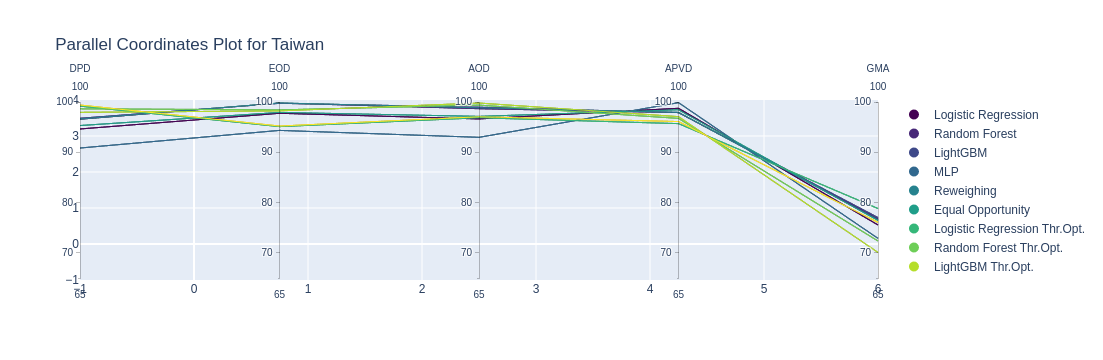

In [39]:
# Load the dataset
df = pd.read_csv('results/taiwan_fairness_metrics.csv')


# Mapping each model to a unique color
color_mapping = {model: idx for idx, model in enumerate(df['Unnamed: 0'].unique())}

# Adjust fairness metrics to be "the higher the better" and scale them to be between 0 and 100
for col in ['DPD', 'EOD', 'AOD', 'APVD']:
    df[col] = (1 - np.abs(df[col])) * 100

# Scale the performance metrics to be between 0 and 100
df['GMA'] *= 100
#df_latest_adjusted['balanced_accuracy'] *= 100

# Generate the required number of colors from the Viridis colorscale
num_colors = len(color_mapping)
colors = px.colors.sequential.Viridis
manual_colors = [colors[i * (len(colors) - 1) // (num_colors - 1)] for i in range(num_colors)]

# Create the Advanced Parallel Coordinates Plot with adjusted data
fig = go.Figure(data=
    go.Parcoords(
        line=dict(color=df['Unnamed: 0'].map(color_mapping),
                  colorscale='Viridis',
                  showscale=False),
        dimensions=[
            dict(label='DPD', values=df['DPD'], range=[65, 100]),
            dict(label='EOD', values=df['EOD'], range=[65, 100]),
            dict(label='AOD', values=df['AOD'], range=[65, 100]),
            dict(label='APVD', values=df['APVD'], range=[65, 100]),
            dict(label='GMA', values=df['GMA'], range=[65, 100])
            #dict(label='balanced_accuracy', values=df_latest_adjusted['balanced_accuracy'], range=[65, 100])
        ]
    )
)

# Add models to the legend using the dummy scatter plot approach and specified manual colors
for idx, (model, color) in enumerate(color_mapping.items()):
    fig.add_trace(
        go.Scatter(x=[None], y=[None],
                   mode='markers',
                   marker=dict(size=10, color=manual_colors[idx]),
                   name=model,
                   showlegend=True)
    )

# Update the layout and adjust the top margin
fig.update_layout(title='Parallel Coordinates Plot for Taiwan', margin=dict(t=100))

# Show the plot
fig.show()

## Explainability

**TODO**

*   Add easy way to include default parameters in optuna
*   Warnings on pipeline given numeric unique number of values
